# Шейплеты и временные ряды  

В этом блокноте наша цель — познакомить с использованием шейплетов для временных рядов. И первый раз мы поработаем с библиотекой *aeon*, документацию по которой можно прочесть по ссылке [документации](https://www.aeon-toolkit.org/en/stable/).

 Мы приводем примеры использования преобразований, классификации и регрессионных оценок на основе шейплетов с двумя наборами данных примеров KDD. Мы также посмотрим, как использовать инструменты визуализации, связанные с этими оценщиками.

In [1]:
!pip install aeon==0.11.0
!mkdir -p data
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_MTSC_TRAIN.ts -P data/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_MTSC_TEST.ts -P data/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_UTSC_TRAIN.ts -P data/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_UTSC_TEST.ts -P data/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_MTSER_TRAIN.ts -P data/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_MTSER_TEST.ts -P data/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_UTSER_TRAIN.ts -P data/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_UTSER_TEST.ts -P data/

�������� ��� 䠩� data 㦥 �������.
�訡�� �� �६� ��ࠡ�⪨: data.
"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [2]:
# There are some deprecation warnings present in the notebook, we will ignore them.
# Remove this cell if you are interested in finding out what is changing soon, for
# aeon there will be big changes in out v1.0.0 release!
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

Давайте сначала сделаем импорт и загрузим наборы данных (это может занять некоторое время, если вы импортируете их впервые!):

In [3]:
import numpy as np
from aeon.datasets import load_classification
from aeon.transformations.collection.shapelet_based import (
    RandomShapeletTransform,
)
from aeon.classification.shapelet_based import (
    ShapeletTransformClassifier,
    RDSTClassifier,
)
from aeon.testing.data_generation import make_example_3d_numpy

Поскольку большинство импортированных нами оценщиков используют numba, первый вызов методов fit/predict потребует некоторого времени для компиляции функций и их кэширования. Чтобы ускорить компиляцию, при первом вызове их в вашей системе вы можете вызвать их для фиктивного набора данных с определенным набором параметров (это может занять ~ 1-2 минуты):

In [4]:
X = make_example_3d_numpy(return_y=False, n_cases=5)
y = np.array([0, 1, 0, 1, 0])
for classifier in [
    ShapeletTransformClassifier,
    RDSTClassifier,
]:
    print(f"Compiling {classifier.__name__}")
    classifier(**classifier.get_test_params()).fit(X, y).predict(X)

Compiling ShapeletTransformClassifier
Compiling RDSTClassifier


Вы можете выполнить указанную выше ячейку еще раз и увидеть, что теперь она выполняется мгновенно! (Обратите внимание, что у RDST есть параметр distance, который, если его изменить, вызовет новый этап компиляции). 

Теперь мы загружаем пример набора данных:

In [5]:
# The original scale of the dataset is extremely small ! (~1e-5).
# to avoid issues with some computational methods, we standardize it
# to obtain a reasonable scale
X_train, y_train = load_classification("KDD_UTSC", split="TRAIN")
X_test, y_test = load_classification("KDD_UTSC", split="TEST")

# Машинное обучение временных рядов на основе шейплетов 

Структура классификации (классификации) на основе шейплетов представлена на изображении ниже:

<img src="data\aeon\shp_general.png?raw=1" alt="drawing" width="700"/>

Сначала шейплеты $k$ генерируются с использованием обучающих данных (с параметром $k$), затем, выполняя преобразование шейплетов с сгенерированными шейплетами и некоторым набором данных временных рядов с $n$ выборками, мы получаем матрицу признаков размера $(n,k)$, эта матрица затем используется табличным классификатором, например, каждая выборка описывается $k$ признаками, полученными с помощью шейплетов. 

Этот шаг создания шейплета и извлечения признаков можно выполнить с помощью оценщиков в `aeon.transformation.collection.shapelet_based`, например, используя `RandomShapeletTransform`:

In [6]:
rst = RandomShapeletTransform().fit(
    X_train, y_train
)
X_T = rst.transform(X_test)
print(X_test.shape)
print(X_T.shape)

(40, 1, 100)
(40, 67)


## Какие функции извлекаются с помощью фигурок? 

Признаки, извлеченные с помощью шейплетов, извлекаются из вектора расстояния, который хранит расстояние между шейплотом $S$ (размера $l$) и каждой подпоследовательностью того же размера во временном ряду $X$. Например, RandomShapeletTransform извлекает минимум из этого вектора расстояния. Более формально, используя евклидово расстояние:

$\displaystyle{\min\limits_{i\ :1, \ldots, m-l+1} \sqrt{\sum_{j=0}^{l-1}(\mathbf{s}_j - \mathbf{x}_{i+j})^2}}$

Это отражает основную идею о том, что расстояние шейплета до временного ряда определяется как расстояние между шейплетом и наиболее подходящей подпоследовательностью того же размера в $X$. Мы можем проиллюстрировать эту формулу следующим изображением, где мы извлекаем минимум из значений $v$ :

<img src="data\aeon\ex_shp_simple.png?raw=1" alt="drawing" width="500"/>

(Немного не по теме, но такой вектор расстояния можно эффективно вычислить с помощью оценщика `QuerySearch` в модуле `similarity_search`, используя шейплет в качестве запроса.)

Обратите внимание, что в других средствах оценки, таких как RandomDilatedShapeletTransform, размер матрицы признаков на самом деле равен $(n, 3k)$, поскольку из каждой фигуры извлекаются 3 признака: 

- $\text{argmin} V$ : местоположение наилучшего соответствия, где местоположение – это положение передней части шейплета. 
- $\sum_i I(v_i < \lambda)$ : признак появления шейплета, который подсчитывает, сколько раз $S$ был $\lambda$-близок к $X$ (с $I$ — тождественной функцией). 

Добавление большего количества функций позволяет шейплетам быть дискриминационными по большему количеству критериев (количество совпадений $\lambda-close$, местоположение наилучшего совпадения), чем только расстояние наилучшего совпадения.

Еще одна интересная идея заключается в том, как шейплоты генерируются из входных временных рядов. А пока просто знайте, что либо производится исчерпывающий поиск с учетом всех возможных кандидатов, либо этот поиск аппроксимируется с использованием эвристик или случайных подходов. Также возможно изучить шейплоты, и это подход, используемый в «LearningShapeletClassifier».

# Шейплеты для классификации (или регрессии)

Теперь, когда мы понимаем основы, мы можем начать использовать классификаторы на основе шейплетов, такие как «ShapeletTransformClassifier» (или «RDSTRegressor» для регрессии). Метод fit будет извлекать фигурки, выполнять преобразование обучающих данных и по умолчанию обучать классификатор RotationForestClassifier на преобразованных данных. Вы можете выбрать, какой классификатор вы хотите использовать, либо с помощью параметра «оценщик», либо самостоятельно построив конвейер на основе преобразования. Например, с помощью средства оценки RidgeClassifierCV:

In [7]:
from sklearn.linear_model import RidgeClassifierCV

stc = ShapeletTransformClassifier(estimator=RidgeClassifierCV(), max_shapelet_length=33).fit(
    X_train, y_train
)
print(f"Accuracy : {stc.score(X_test, y_test)}")

Accuracy : 0.7


Мы можем визуализировать классификаторы на основе шейплетов, используя класс ShapeletClassifierVisualizer, который предоставляет методы для построения сгенерированных шейплетов, векторов расстояний, создаваемых ими признаков и того, как они соответствуют данным. Когда это возможно (в зависимости от типа классификатора), мы также можем построить лучшие фигурки на основе критериев важности признаков из подобранного классификатора. Например, с только что использованным `ShapeletTransformClassifier` (диаграммы рассеяния могут запутаться при использовании длинных фигур!):

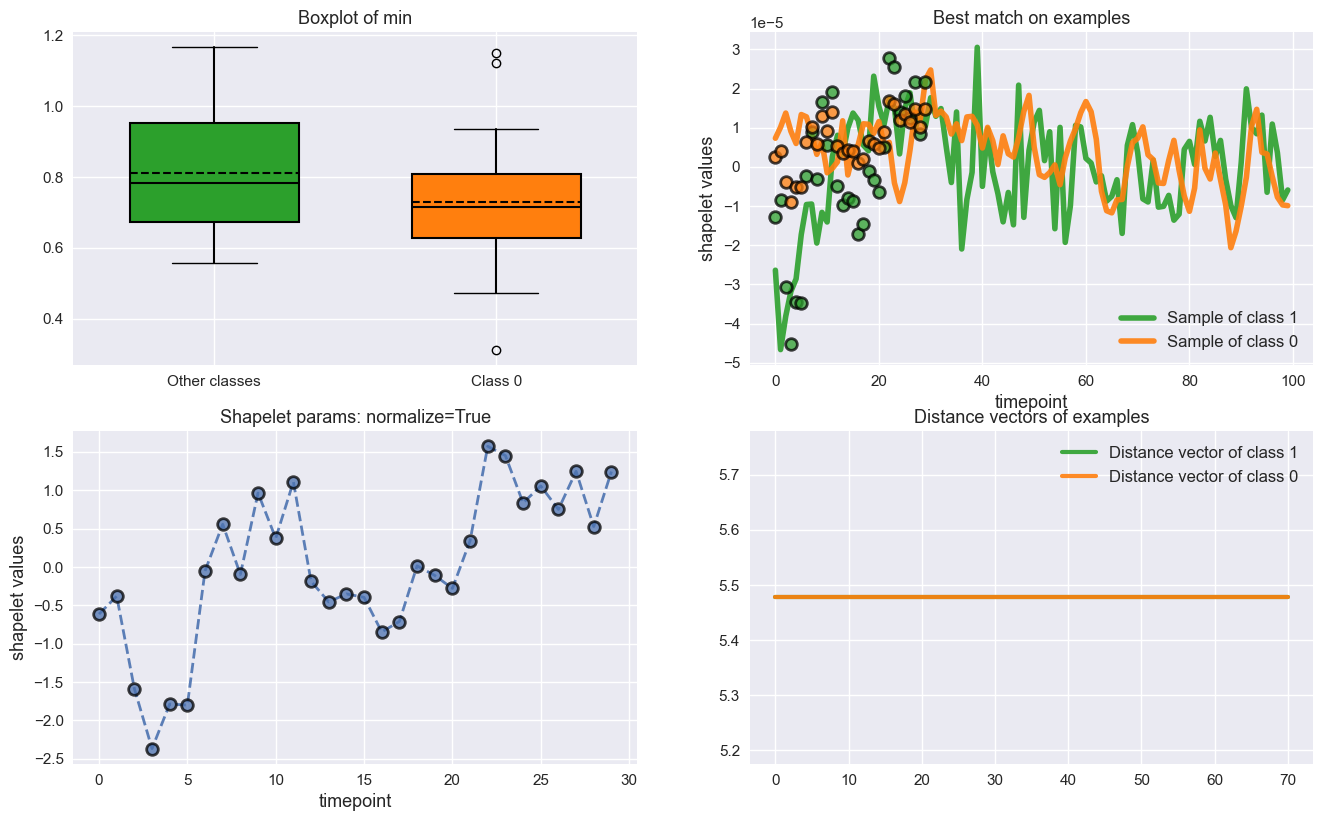

In [9]:
from aeon.visualisation import ShapeletClassifierVisualizer

stc_vis = ShapeletClassifierVisualizer(stc)
id_class = 0 # Show the best shapelet for class 0
fig = stc_vis.visualize_shapelets_one_class(
    X_test,
    y_test,
    id_class,
    figure_options={"figsize": (16,9.5), "nrows": 2, "ncols": 2}, # Some options to make a beatiful plot
    scatter_options={"s": 70,"alpha": 0.75,"zorder": 3,"edgecolor": "black","linewidths": 2}, # Some options to make a beatiful plot
    rc_Params_options={  # Some options to make a beatiful plot
    "legend.fontsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 13,
},
)

Каждый из четырех графиков помогает интерпретировать алгоритмы на основе шейплетов. Здесь мы берем наиболее отличительную от всех форму класса 0 и исследуем ее как на локальные, так и на глобальные закономерности. 

- Boxplot of Min (вверху слева): этот график представляет новую перспективу, фокусируясь на глобальном качестве шейплета. Он показывает распределение минимальных расстояний между шейплотом и каждым временным рядом по разным классам. Как и ожидалось, шейплет соответствует классу 0 больше, чем другим классам. 

- Лучшее совпадение в примерах (вверху справа): этот график расширяет визуализацию наилучшего соответствия, показывая, как шейплет соответствует случайному временному ряду из каждого класса. Зеленые и оранжевые кривые представляют образцы классов 1 и 0 соответственно. Шейплет должен более точно соответствовать временному ряду органжа класса 0, что иллюстрирует его эффективность в различении двух классов в соответствии с локальным шаблоном. 

- Параметры шейплета (внизу слева): этот уже представленный график элегантно отображает динамику шейплета с течением времени. 

- Векторы расстояний примеров (внизу справа): этот график является расширением визуализации вектора расстояния, предлагая сравнение того, насколько хорошо шейплет соответствует двум временным рядам из графика «Наилучшее совпадение примеров» в каждой точке. Это позволяет получить глобальное представление о том, насколько хорошо шейплет соответствует временному ряду в любой момент.

Мы можем попробовать использовать RDSTClassifier, который использует понятие расширения для фигурок, а также извлекает еще 2 функции:

Accuracy : 0.925


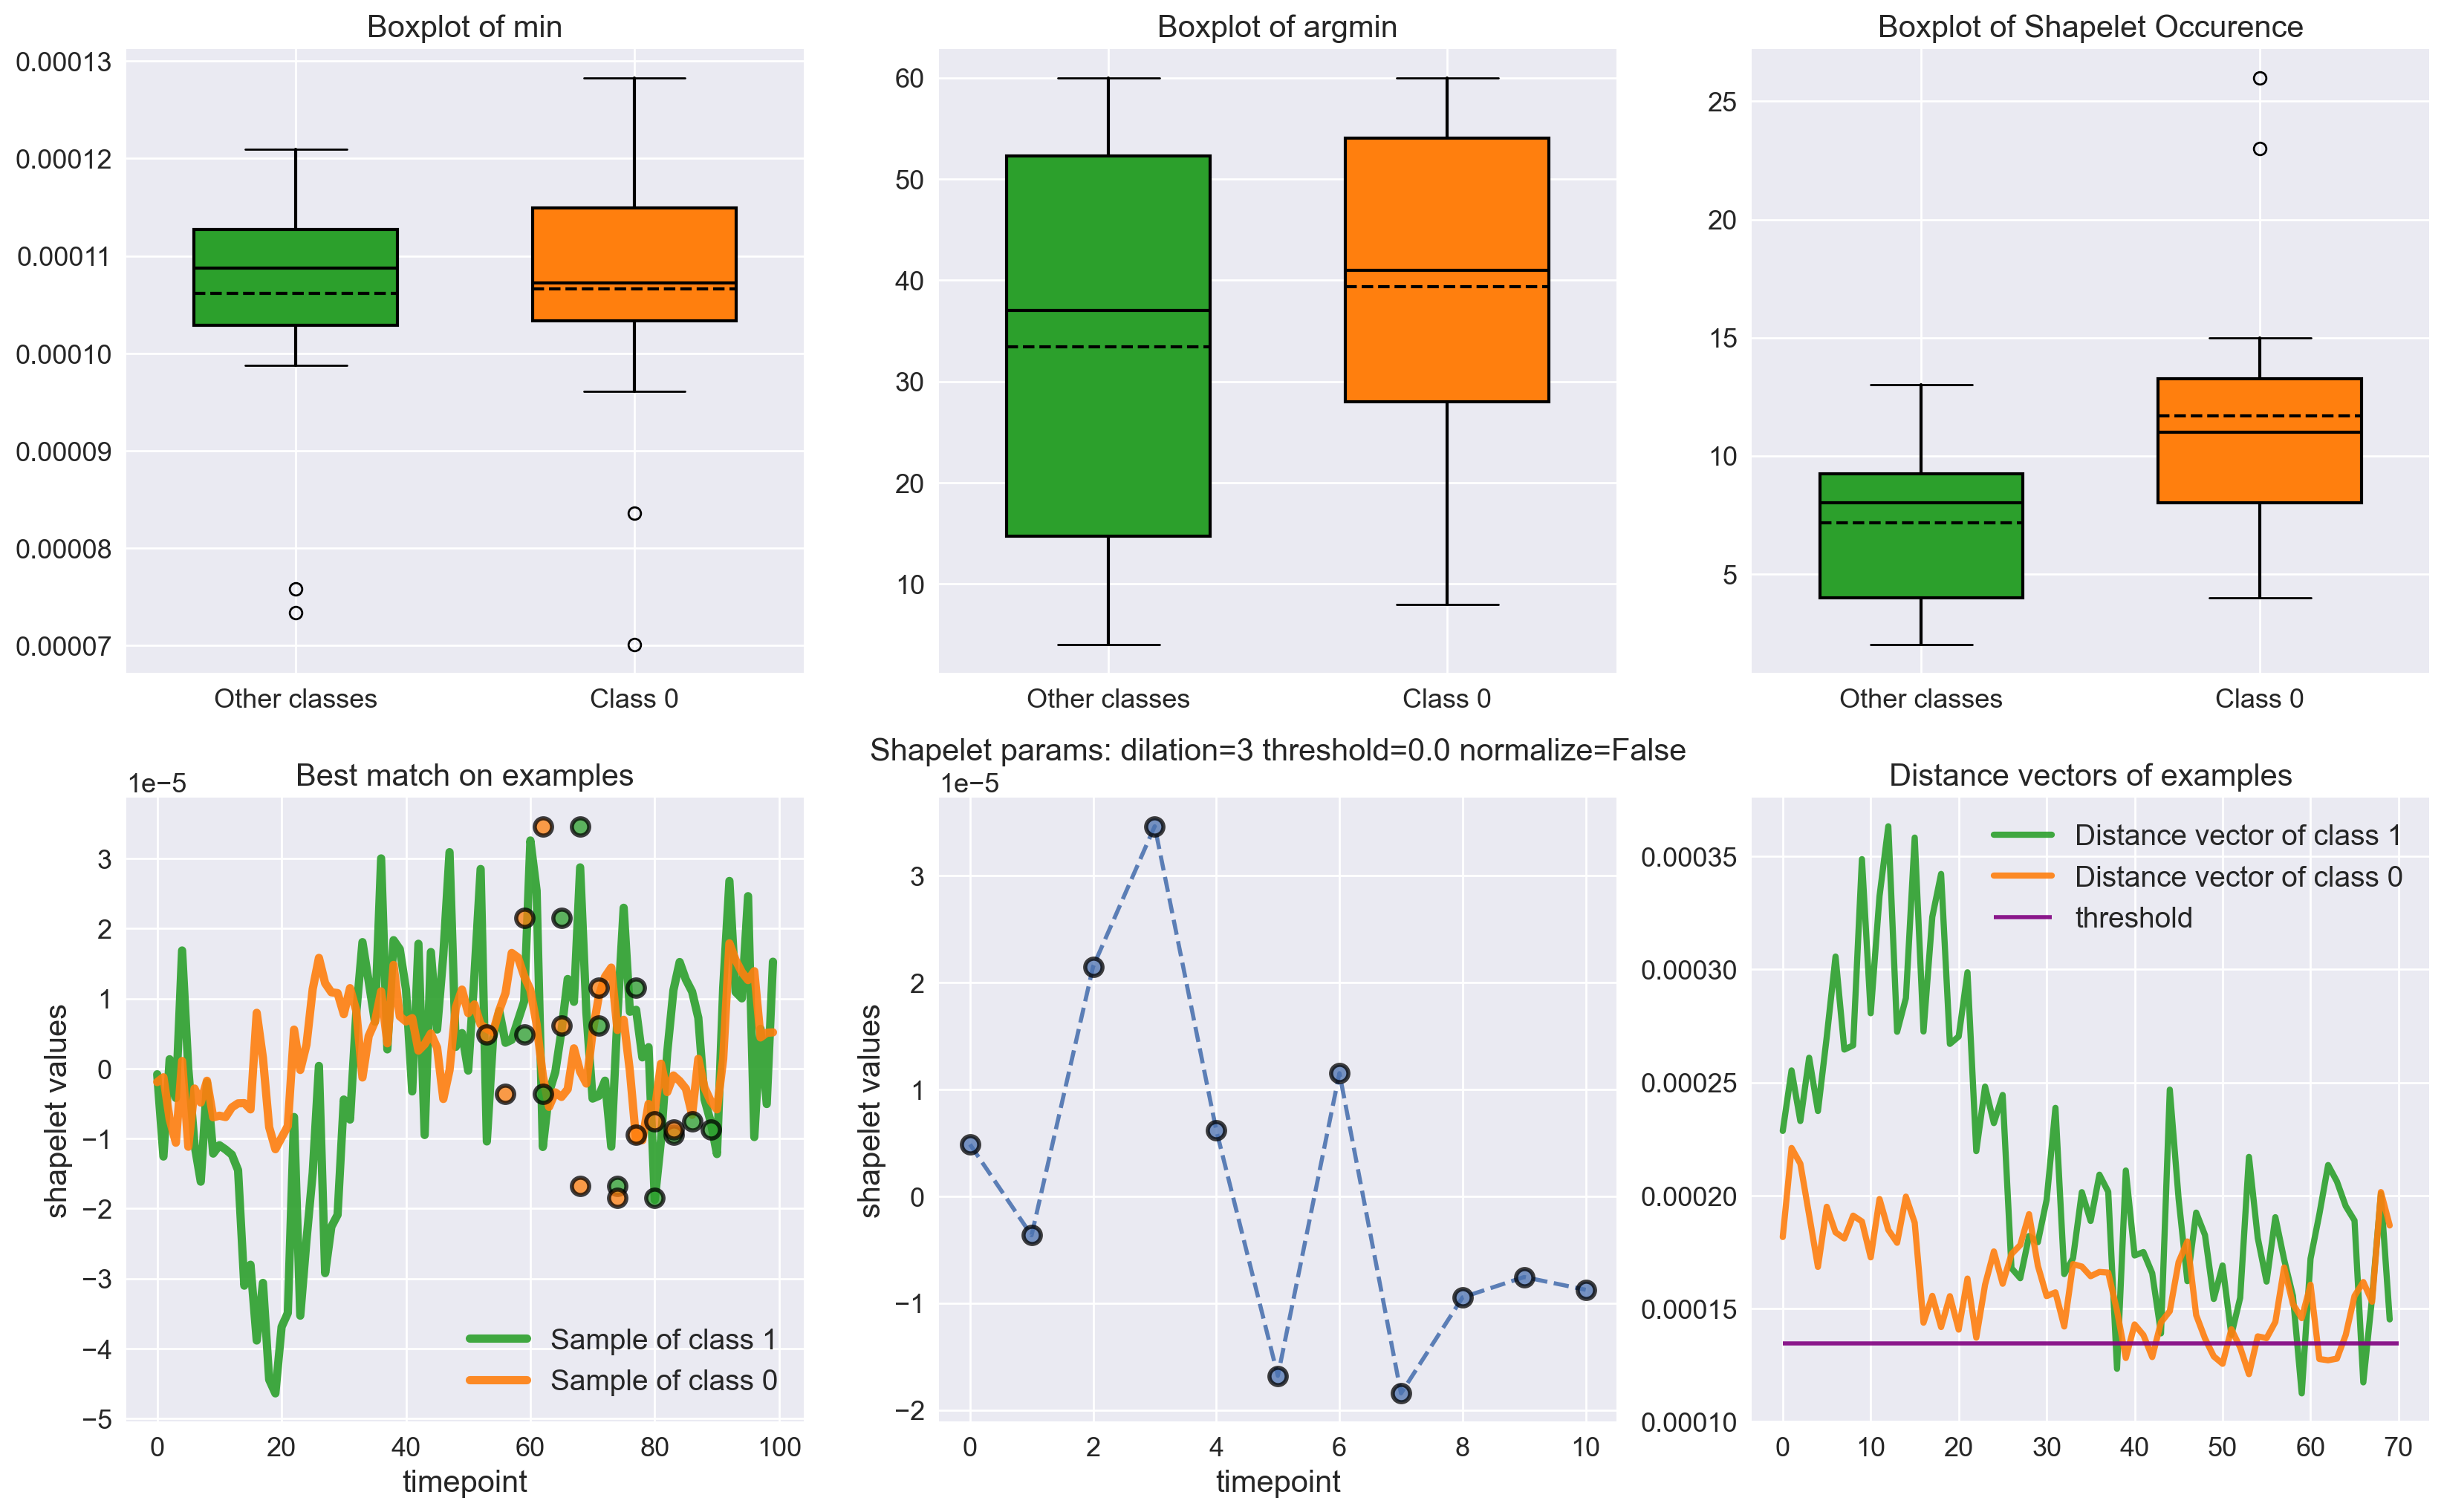

In [10]:
rdst = RDSTClassifier().fit(
    X_train, y_train
)
print(f"Accuracy : {rdst.score(X_test, y_test)}")

rdst_vis = ShapeletClassifierVisualizer(rdst)
id_class = 0 # Best shapelet for class 0
fig = rdst_vis.visualize_shapelets_one_class(
    X_test,
    y_test,
    id_class,
    scatter_options={"s": 70,"alpha": 0.75,"zorder": 3,"edgecolor": "black","linewidths": 2},
)

Доступно множество параметров для распараллеливания или настройки этих оценщиков, **которые поддерживают как многомерные временные ряды, так и временные ряды неравной длины**. Мы советуем вам взглянуть на документацию `aeon` для более глубокого погружения в шейплеты!.

## Результаты бенчмарка TSC

(<Figure size 600x230 with 1 Axes>, <Axes: >)

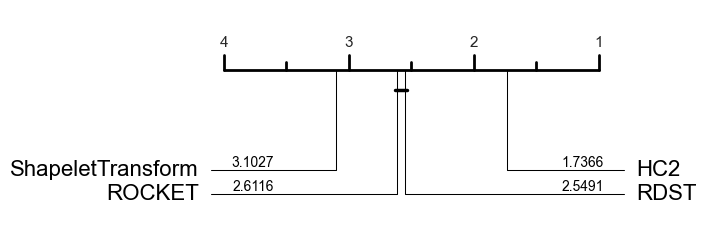

In [11]:
from aeon.benchmarking import get_estimator_results_as_array
from aeon.datasets.tsc_datasets import univariate

est = ["ROCKETClassifier", "RDSTClassifier", "ShapeletTransformClassifier", "HC2"]
names = [t.replace("Classifier", "") for t in est]
results, present_names = get_estimator_results_as_array(
    names, univariate, include_missing=False
)

from aeon.visualisation import plot_critical_difference

plot_critical_difference(results, names)

Чтобы сравнить производительность shapelet с другим методом SotA, мы сравниваем RDSTClassifier и ShapeletTransformClassifier с Rocket и HC2. Обратите внимание, что RDST и ROCKET считаются эквивалентными, что неудивительно. А вы сможете объяснить  почему?

## Упражнения  

1. Выбрать и скачать один из наборов данных с сайта [timeseriesclassification](https://www.timeseriesclassification.com/dataset.php). 

    Подробнее о датасетах, их форматах, и как их скачивать - [Ноутбук](https://github.com/aeon-toolkit/aeon/blob/main/examples/datasets/data_loading.ipynb)

2.  Записать название выбранного датасета в таблицу. Помните - совпадений быть не должно. Каждый работает с уникальным датасетом. Этот датасет вам понадобиться в лабе 14 (aeon) и лабе 16 (tslean)

3. Проанализировать датасет

4. Найти шейплеты для классов в датесете

5. Провести классификацию на основе шейплетов.